## 残差网络
欢迎来到本周的第二项作业！你将学习如何使用残差网络（ResNets）构建非常深的卷积网络。理论上讲，更深的网络可以表现更复杂的特征。但实际上，它们很难训练。He et al.引入的残差网络使你可以训练比以前实际可行的深层网络。

**在此作业中，你将**：
- 实现ResNets的基本构建块。
- 将这些模块放在一起，以实现和训练用于图像分类的最新神经网络。

这项作业将使用Keras完成。

在跳入问题之前，让我们运行下面的单元格以加载所需的包。

In [12]:
import numpy as np
# import tensorflow as tf降级
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model 这么引入会报错
from keras.utils.vis_utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\15831\Anaconda3\lib\site-packages\keras\backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


- 我：源代码可能会碰到问题“ImportError: cannot import name 'plot_model'”，参考[解决方案](https://blog.csdn.net/weix1235/article/details/120597186);
    - 所以搜bug的时候，最好加上 吴恩达 ，这样搜的比较准。

### 1 深层神经网络带来的问题
上周，你构建了第一个卷积神经网络。近年来，神经网络变得越来越深，网络已经从最初的几层（例如AlexNet）扩展到了一百多层。

深层网络的主要好处是可以表示非常复杂的特征。它还可以学习许多不同抽象级别的特征，从边缘（较低层）到非常复杂的特征（较深层）。但是，使用更深的网络并不总是好的。训练它们的一个巨大障碍是梯度的消失：非常深的网络通常具有迅速变为零的梯度信号，因此使梯度下降的速度令人难以忍受。更具体地说，在梯度下降过程中，当你从最后一层反向传播回第一层时，你需要在每一步上乘以权重矩阵，因此，梯度可以快速指数下降至零（或者在极少数情况下呈指数增长并“爆炸”为非常大的值）。

因此，在训练过程中，随着训练的进行，你可能会看到较早层的梯度的大小（或范数）非常快地减小到零：
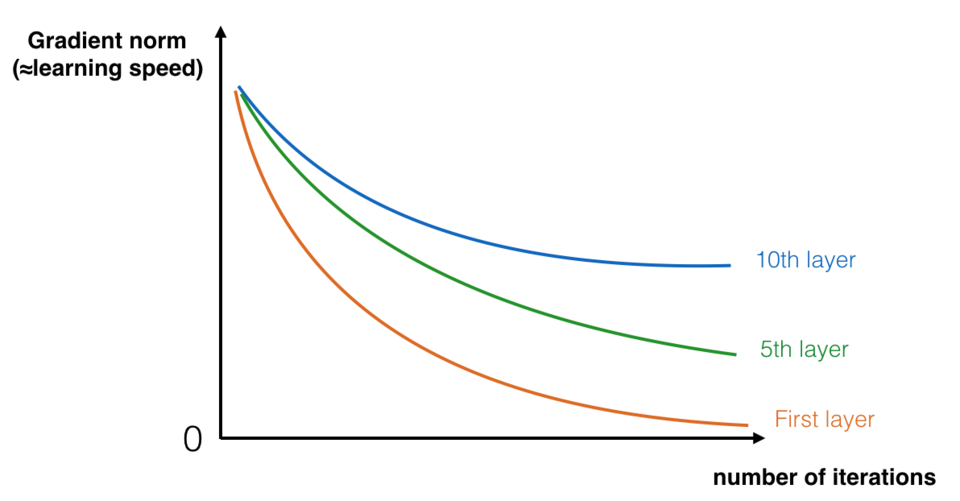

**图1 ：梯度消失**

随着训练，网络学习的速度开始迅速下降

你现在将通过构建残差网络来解决此问题！

### 2 建立残差网络¶
在ResNets中，"shortcut" 或者 "skip connection"允许将梯度直接反向传播到较早的层：

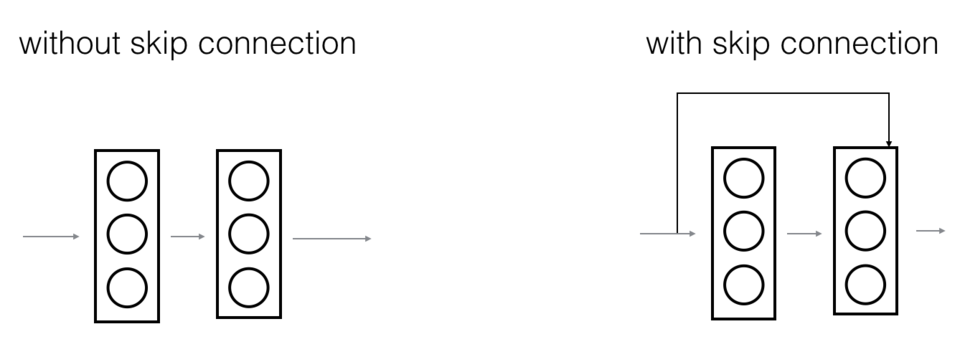

**图2**：显示**skip connection**的残差块

左图显示了通过网络的“主要路径”。右图为主路径添加了shortcut。通过将这些ResNet块彼此堆叠，可以形成一个非常深的网络。

我们在教程中还看到，使用带有shortcut的ResNet块可以非常容易学习标识功能。这意味着你可以堆叠在其他ResNet块上，而几乎不会损害训练集性能。（还有一些证据表明，学习标识功能甚至比skip connections有助于解决梯度消失问题--也说明了ResNets的出色性能。）

ResNet中主要使用两种类型的块，这主要取决于输入/输出尺寸是相同还是不同。你将要在作业中实现两者。

#### 2.1 The identity block
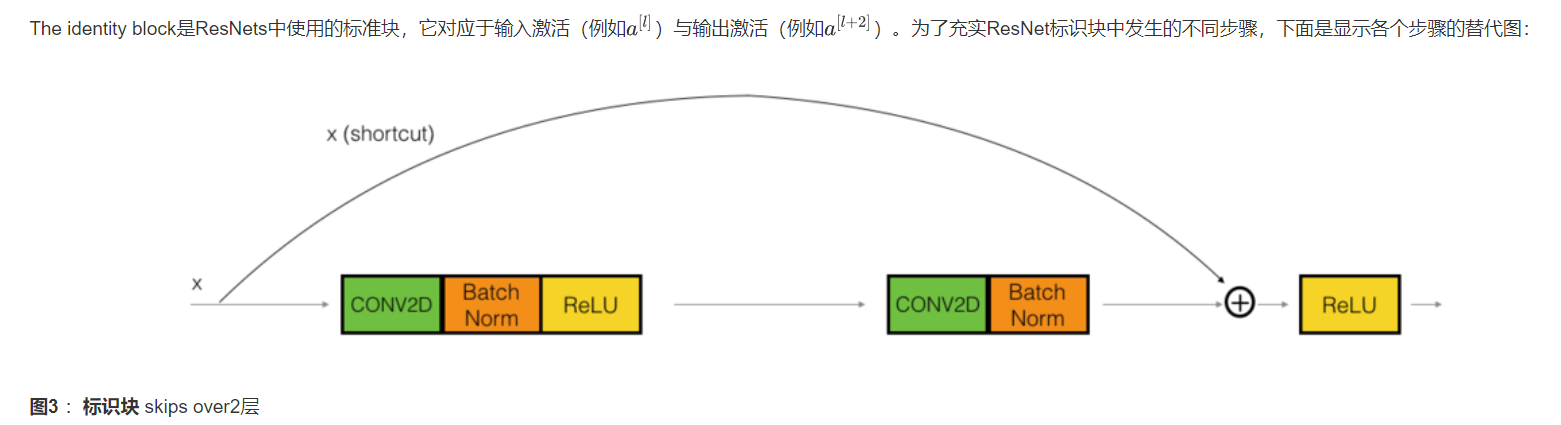

上部路径是“shortcut path”。下部路径是“main path”。在此图中，我们还明确了每一层中的CONV2D和ReLU步骤。为了加快训练速度，我们还添加了BatchNorm步骤。不必担心实现起来很复杂-你会看到BatchNorm只需Keras中的一行代码！

在本练习中，你实际上将实现此识别块的功能稍强的版本，其中跳过连接将"skips over"3个隐藏层而不是2个。看起来像这样：

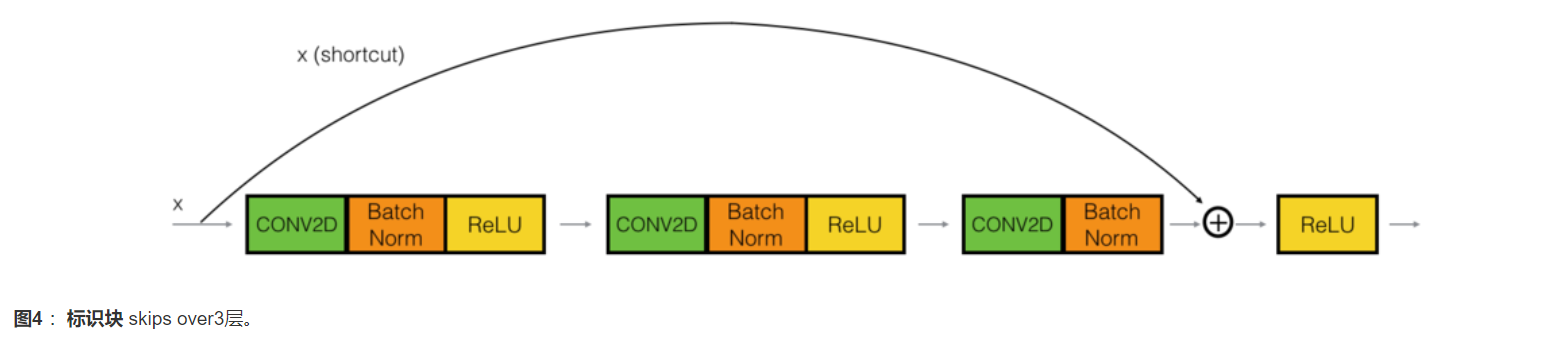

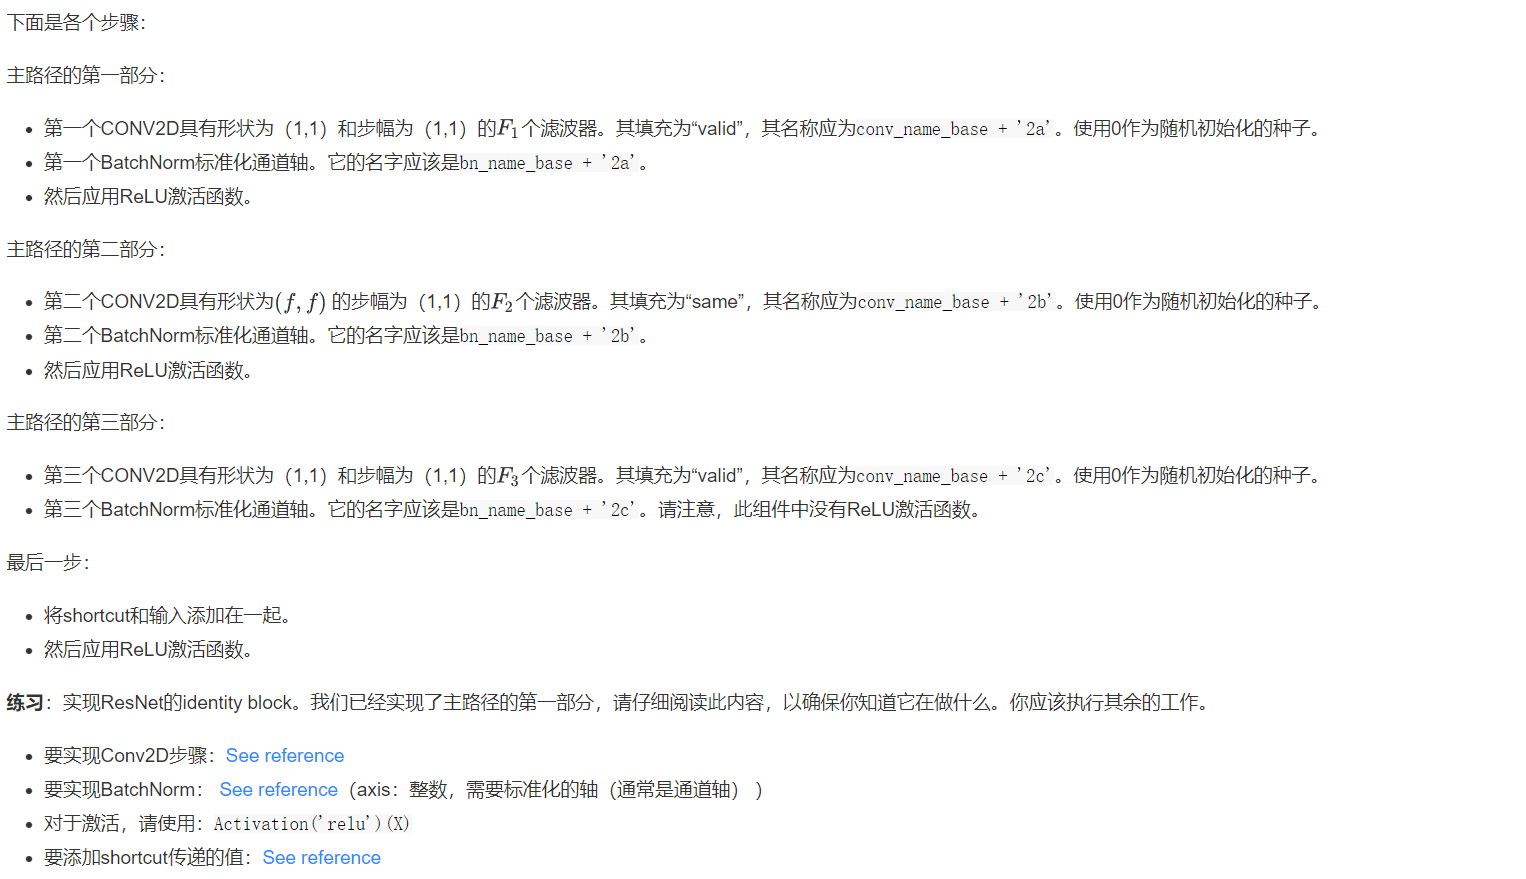

In [13]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.add([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X


In [16]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as test:
    np.random.seed(1)
    A_prev = tf.compat.v1.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.compat.v1.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.        0.        1.3454674 2.031818  0.        1.3246754]


**预期输出**:

out = [0.19716819 0. 1.3561226 2.1713073 0. 1.3324987 ]

#### 2.2 The convolutional block
你已经实现了ResNet中的识别块。接下来，ResNet“卷积块”是另一种类型的块。当输入和输出尺寸不匹配时，可以使用这种类型的块。与标识块的区别在于，shortcut路径中有一个CONV2D层：
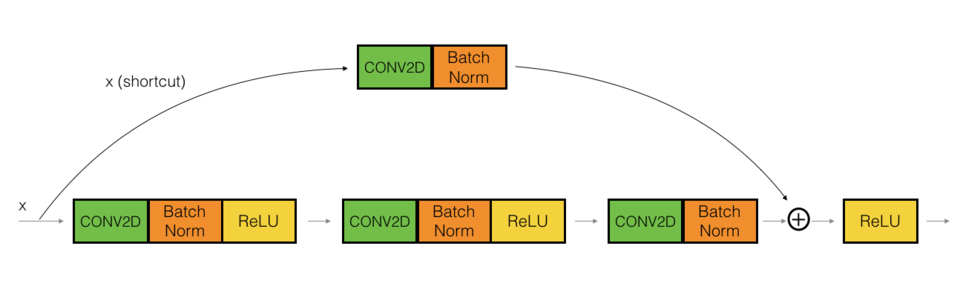
**图4 ：卷积块**

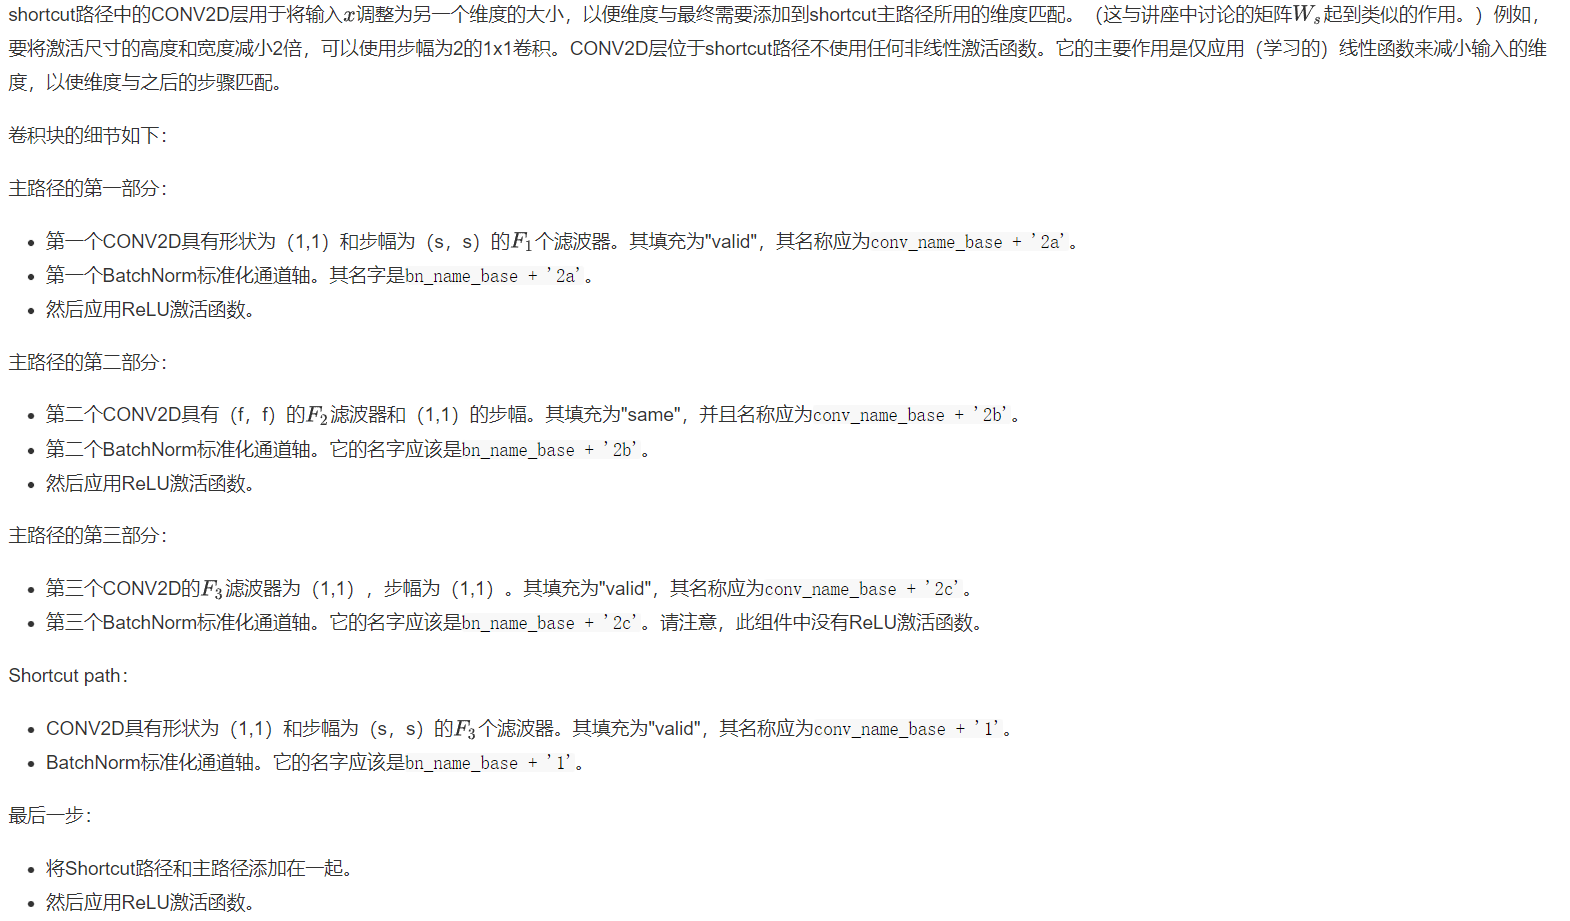

练习：实现卷积模块。我们已经实现了主路径的第一部分；你应该执行其余的工作。和之前一样，使用0作为随机初始化的种子，以确保与评分器的一致性。

- Conv Hint
- BatchNorm Hint （axis：整数，需要标准化的轴（通常是特征轴））
- 激活函数请使用：Activation('relu')(X)
- Addition Hint


In [18]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), name = conv_name_base + '2b',padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), name = conv_name_base + '2c',padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), name = conv_name_base + '1',padding='valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.add([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [19]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

**预期输出**:

out = [0.09018463 1.2348979 0.46822023 0.03671762 0. 0.65516603]


### 3 建立你的第一个ResNet模型（50层）
现在，你具有构建非常深的ResNet的必要块。下图详细描述了此神经网络的体系结构。图中的“ID BLOCK”代表“识别块”，“ID BLOCK x3”表示你应该将3个识别块堆叠在一起。
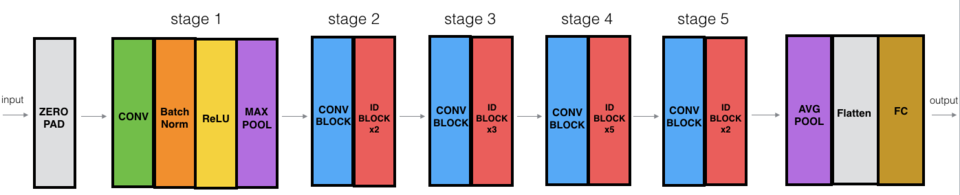
**图5 ：ResNet50 模型**

此ResNet-50模型的详细结构是：

- 零填充填充（3,3）的输入
- 阶段1：
    - 2D卷积具有64个形状为（7,7）的滤波器，并使用（2,2）步幅，名称是“conv1”。
    - BatchNorm应用于输入的通道轴。
    - MaxPooling使用（3,3）窗口和（2,2）步幅。
- 阶段2：
    - 卷积块使用三组大小为[64,64,256]的滤波器，“f”为3，“s”为1，块为“a”。
    - 2个标识块使用三组大小为[64,64,256]的滤波器，“f”为3，块为“b”和“c”。
- 阶段3：
    - 卷积块使用三组大小为[128,128,512]的滤波器，“f”为3，“s”为2，块为“a”。
    - 3个标识块使用三组大小为[128,128,512]的滤波器，“f”为3，块为“b”，“c”和“d”。
- 阶段4：
    - 卷积块使用三组大小为[256、256、1024]的滤波器，“f”为3，“s”为2，块为“a”。
    - 5个标识块使用三组大小为[256、256、1024]的滤波器，“f”为3，块为“b”，“c”，“d”，“e”和“f”。
- 阶段5：
    - 卷积块使用三组大小为[512、512、2048]的滤波器，“f”为3，“s”为2，块为“a”。
    - 2个标识块使用三组大小为[256、256、2048]的滤波器，“f”为3，块为“b”和“c”。
- 2D平均池使用形状为（2,2）的窗口，其名称为“avg_pool”。
- Flatten层没有任何超参数或名称。
- 全连接（密集）层使用softmax激活将其输入减少为类数。名字是'fc' + str(classes)。

**练习**：使用上图中的描述实现50层的ResNet。我们已经执行了第一阶段和第二阶段。请执行其余的步骤。（实现阶段3-5的语法应与阶段2的语法相似）请确保遵循上面文本中的命名。
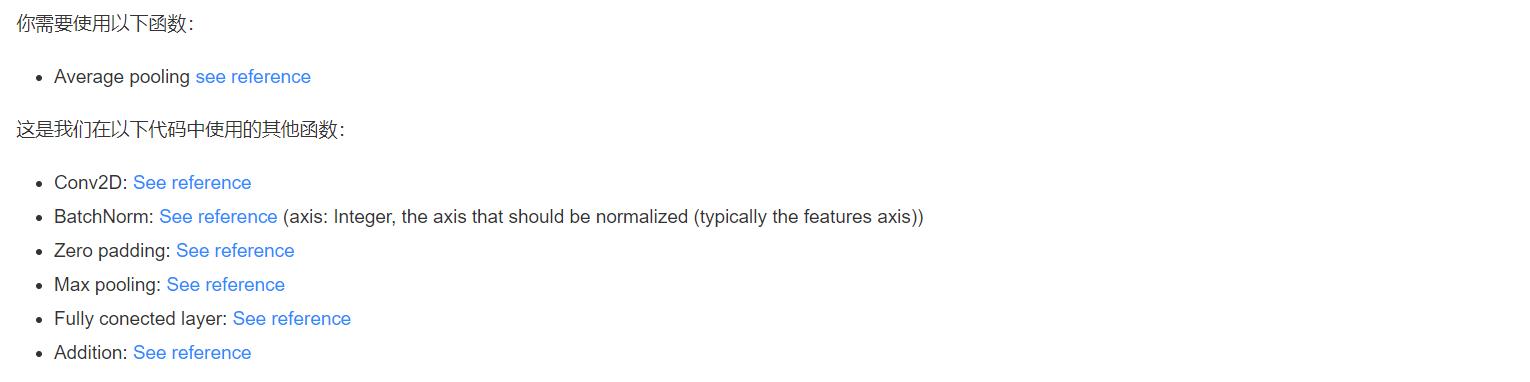

In [20]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    # The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    # The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
    X = convolutional_block(X, f = 3, filters=[128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, f = 3, filters=[128,128,512], stage= 3, block='b')
    X = identity_block(X, f = 3, filters=[128,128,512], stage= 3, block='c')
    X = identity_block(X, f = 3, filters=[128,128,512], stage= 3, block='d')

    # Stage 4 (≈6 lines)
    # The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    # The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
    X = convolutional_block(X, f = 3, filters=[256, 256, 1024], block='a', stage=4, s = 2)
    X = identity_block(X, f = 3, filters=[256, 256, 1024], block='b', stage=4)
    X = identity_block(X, f = 3, filters=[256, 256, 1024], block='c', stage=4)
    X = identity_block(X, f = 3, filters=[256, 256, 1024], block='d', stage=4)
    X = identity_block(X, f = 3, filters=[256, 256, 1024], block='e', stage=4)
    X = identity_block(X, f = 3, filters=[256, 256, 1024], block='f', stage=4)

    # Stage 5 (≈3 lines)
    # The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    # The 2 identity blocks use three set of filters of size [256, 256, 2048], "f" is 3 and the blocks are "b" and "c".
    X = convolutional_block(X, f = 3, filters=[512, 512, 2048], stage=5, block='a', s = 2)
    
    # filters should be [256, 256, 2048], but it fail to be graded. Use [512, 512, 2048] to pass the grading
    X = identity_block(X, f = 3, filters=[256, 256, 2048], stage=5, block='b')
    X = identity_block(X, f = 3, filters=[256, 256, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    # The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
    X = AveragePooling2D(pool_size=(2,2))(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


运行以下代码以构建模型图。如果你的实现不正确，则可以通过运行下面的model.fit（...）时检查准确性

In [21]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

如在Keras教程笔记本中所见，在训练模型之前，你需要通过编译模型来配置学习过程。

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

现在可以训练模型了。 你唯一需要的就是数据集。

加载SIGNS数据集。
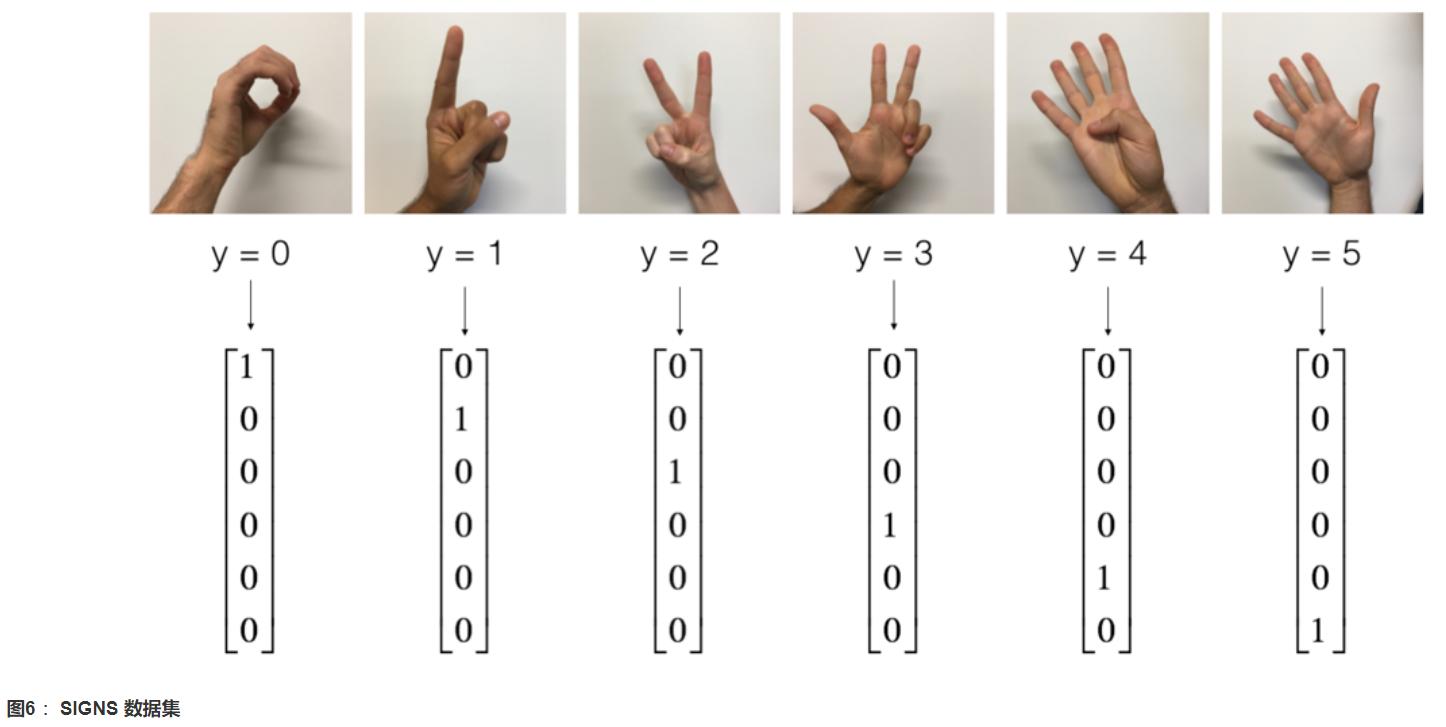

In [24]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


运行以下单元格，训练模型（批处理大小为32）2个epoch。在CPU上，每个epoch大约需要5分钟。

In [25]:
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Train on 1080 samples
Epoch 1/20
1080/1080 [==============================] - 24s 22ms/sample - loss: 1.7603 - acc: 0.4778
Epoch 2/20
1080/1080 [==============================] - 22s 20ms/sample - loss: 0.6265 - acc: 0.7833
Epoch 3/20
1080/1080 [==============================] - 21s 20ms/sample - loss: 0.4249 - acc: 0.8519
Epoch 4/20
1080/1080 [==============================] - 23s 21ms/sample - loss: 0.4247 - acc: 0.8630
Epoch 5/20
1080/1080 [==============================] - 25s 23ms/sample - loss: 0.2189 - acc: 0.9269
Epoch 6/20
1080/1080 [==============================] - 26s 24ms/sample - loss: 0.1810 - acc: 0.9417
Epoch 7/20
1080/1080 [==============================] - 26s 24ms/sample - loss: 0.1295 - acc: 0.9556
Epoch 8/20
1080/1080 [==============================] - 25s 23ms/sample - loss: 0.3553 - acc: 0.9074
Epoch 9/20
1080/1080 [==============================] - 25s 23ms/sample - loss: 0.2778 - acc: 0.9185
Epoch 10/20
1080/1080 [==============================] - 25s 23ms/sam

**Expected Output**:
Epoch 1/20

1080/1080 [==============================] - 198s 183ms/step - loss: 2.7697 - acc: 0.2880

Epoch 2/20

1080/1080 [==============================] - 187s 173ms/step - loss: 1.8029 - acc: 0.4815

...

Epoch 19/20

1080/1080 [==============================] - 187s 173ms/step - loss: 0.0632 - acc: 0.9787

Epoch 20/20

1080/1080 [==============================] - 186s 173ms/step - loss: 0.1022 - acc: 0.9630

让我们看看这个模型（仅在训练了2个epoch）在测试集上的表现。

In [26]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

C:\Users\15831\Anaconda3\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Loss = 1.1851609071095786
Test Accuracy = 0.8333333


**预期输出**:

Loss = 0.47188322941462196

Test Accuracy = 0.8916666626930236

为了完成这项作业，我们已要求你仅在两个epoch内训练模型。尽管它表现不佳，也请继续提交作业； 为了检查正确性，在线评分器也将仅在几个epoch内运行你的代码。

#### 示例训练模型（未提供）
完成此任务的正式（分级）部分后，如果需要，你还可以选择训练ResNet进行更多epoch。训练约20个epoch时，我们会获得更好的性能，但是在CPU上进行训练将需要一个多小时。

使用GPU，我们已经在SIGNS数据集上训练了自己的ResNet50模型的权重。你可以在下面的单元格中的测试集上加载并运行我们训练好的模型。加载模型可能需要大约1分钟。

In [27]:
# model = load_model('ResNet50.h5') #这里要读模型，我们可以先沿用老的模型

In [28]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Loss = 1.1851609071095786
Test Accuracy = 0.8333333


如果对ResNet50进行足够数量的迭代训练，则它将是用于图像分类的强大模型。我们希望你可以使用所学的知识并将其应用于你自己的分类问题，以实现最新的准确性。

恭喜你完成此作业！你现在已经实现了一个优异的图像分类系统！

### 4 测试你自己的图片（可选练习）
如果愿意，你也可以拍自己的手的照片并查看模型的输出。 你可以：

1. 单击此笔记本上部栏中的"File"，然后单击"Open"以在Coursera Hub上运行。   
2. 将图像添加到Jupyter Notebook的目录中，在"images"文件夹中
3. 在以下代码中写下你的图片名称
4. 运行代码，然后检查算法是否正确！

In [29]:
img_path = 'my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

FileNotFoundError: [Errno 2] No such file or directory: 'my_image.jpg'

你还可以通过运行以下代码来打印模型的摘要。

```python
model.summary()
```

最后，运行下面的代码以可视化你的ResNet50。你也可以通过转到"File -> Open...-> model.png".下载模型的.png图片。

In [30]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


AttributeError: 'NoneType' object has no attribute 'create'

打印出来的结构如下：
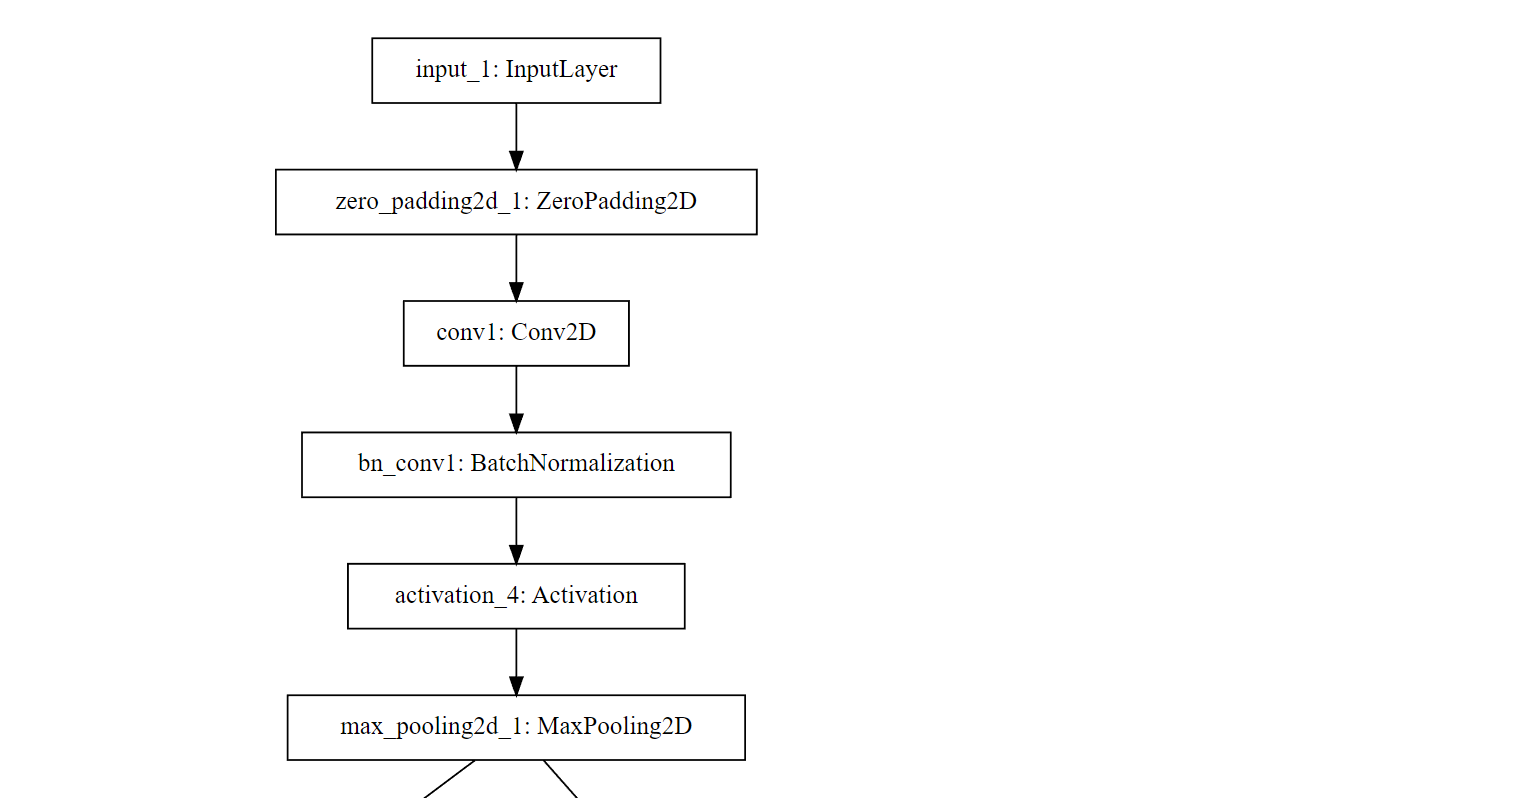

更多图像展示略